<a href="https://colab.research.google.com/github/jackasser/FileMaker-coreML/blob/main/lenier_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install coremltools

     |████████████████████████████████| 1.6 MB 4.1 MB/s 


In [25]:
!pip install --force-reinstall 'scikit-learn==0.19.2' 

     |████████████████████████████████| 4.9 MB 4.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 0.9.1 requires scikit-learn>=0.20, but you have scikit-learn 0.19.2 which is incompatible.
imbalanced-learn 0.4.3 requires scikit-learn>=0.20, but you have scikit-learn 0.19.2 which is incompatible.


In [19]:
# 使用するデータのダウンロード
!git clone https://github.com/jackasser/FileMaker-coreML.git

Cloning into 'FileMaker-coreML'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import coremltools

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [43]:
%matplotlib inline

# データの読み込み
df_data = pd.read_csv("/content/FileMaker-coreML/取り込み用.csv")


In [44]:
# データ確認
df_data.head()

,記録日,作物PK,気温,湿度,土中湿度,元気
0,2021/06/28 8:50:30,FAF90C9F-794A-46F2-A538-AA8B2897848D,26.6,51.68,66,2
1,2021/06/28 11:49:34,FAF90C9F-794A-46F2-A538-AA8B2897848D,25.0,56.25,54,0
2,2021/06/28 12:19:40,FAF90C9F-794A-46F2-A538-AA8B2897848D,25.0,55.98,64,1
3,2021/06/28 12:49:47,FAF90C9F-794A-46F2-A538-AA8B2897848D,25.0,55.81,64,1
4,2021/06/28 13:19:53,FAF90C9F-794A-46F2-A538-AA8B2897848D,24.8,55.47,64,1


In [17]:
# データ情報
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391 entries, 0 to 1390
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   記録日     1391 non-null   object 
 1   作物PK    1391 non-null   object 
 2   気温      1391 non-null   float64
 3   湿度      1391 non-null   float64
 4   土中湿度    1391 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 54.5+ KB


In [18]:
# データの統計情報
df_data.describe()

,気温,湿度,土中湿度
count,1391.000000,1391.000000,1391.000000
mean,26.315457,50.335953,80.907261
std,1.278353,25.600224,9.738710
min,22.600000,-87.000000,53.000000
25%,25.300000,38.820000,74.000000
50%,26.400000,49.000000,80.000000
75%,27.200000,62.000000,90.000000
max,29.400000,153.000000,95.000000


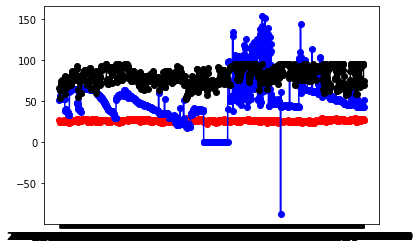

In [19]:
# ↑湿度の最小値(min）と最大値（max）がおかしい


# データを折線グラフで可視化
plt.plot(df_data.記録日, df_data.気温, color = 'red', marker = 'o')
plt.plot(df_data.記録日, df_data.湿度, color = 'blue', marker = 'o')
plt.plot(df_data.記録日, df_data.土中湿度, color = 'black', marker = 'o')
plt.show()


In [20]:
# ↑湿度に外れ値があるため外れ値を削除する

# 値を大きい順にならべたときに小さい方から１０％の順番の値をqに代入
q=df_data.湿度.quantile(0.1)
# qより小さい値は外れ値として除外
new_df = df_data.query('湿度>@q')
# 湿度が100を超えて記録されているものは外れ値として除外
new_df = new_df.query('湿度<100')

In [21]:
# 整形後のデータの統計情報を表示
new_df.describe()

,気温,湿度,土中湿度
count,1184.000000,1184.000000,1184.000000
mean,26.355236,52.078454,81.447635
std,1.252193,15.220931,9.700884
min,23.300000,22.340000,54.000000
25%,25.400000,42.820000,74.000000
50%,26.400000,50.280000,81.000000
75%,27.300000,61.000000,90.000000
max,29.400000,99.000000,95.000000


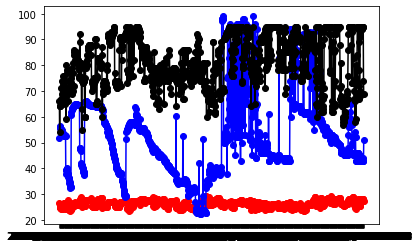

In [22]:
# ↑湿度の標準偏差が減少し、最大値と最小値が正常になった

# 整形後のデータを可視化
plt.plot(new_df.記録日, new_df.気温, color = 'red', marker = 'o')
plt.plot(new_df.記録日, new_df.湿度, color = 'blue', marker = 'o')
plt.plot(new_df.記録日, new_df.土中湿度, color = 'black', marker = 'o')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1391 entries, 0 to 1390
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   記録日     1391 non-null   object 
 1   作物PK    1391 non-null   object 
 2   気温      1391 non-null   float64
 3   湿度      1391 non-null   float64
 4   土中湿度    1391 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 54.5+ KB


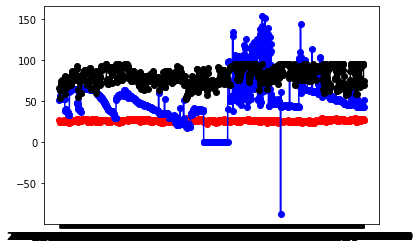

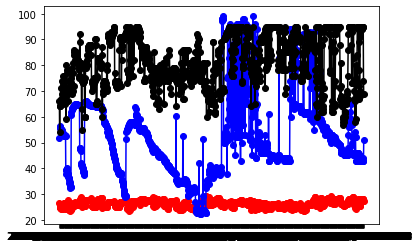

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 0 to 1390
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   記録日     1184 non-null   object 
 1   気温      1184 non-null   float64
 2   湿度      1184 non-null   float64
 3   土中湿度    1184 non-null   int64  
 4   元気      1184 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 55.5+ KB


In [2]:
# ダミーで教師データを付与

new_df.head()

new_df = new_df.drop('作物PK',axis=1)

new_df.head()

new_df['元気'] = 0

# 土中湿度-60:元気0
# 60-65:元気1
# 65-70:元気2
# 70-:元気３
new_df.loc[new_df['土中湿度']<=60,'元気'] = 0
new_df.loc[new_df['土中湿度']>=60,'元気'] = 1
new_df.loc[new_df['土中湿度']>=65,'元気'] = 2
new_df.loc[new_df['土中湿度']>=70,'元気'] = 3


new_df.describe()

new_df.info()

new_df["土中湿度"]  =new_df["土中湿度"] .astype('float64')

new_df.to_csv("for_coreML.csv")

X_train, X_test, y_train, y_test = train_test_split(new_df[['気温','湿度','土中湿度']], new_df.元気, random_state=0)


In [14]:

clf = LinearRegression()
clf.fit(X_train, y_train)

print(clf.predict([[0, 0,  90]]))

y_pred =clf.predict(X_test)



accuracy_score(y_pred.round().astype(int), y_test)

# CoreMLに変換
import coremltools
coreml_model = coremltools.converters.sklearn.convert(clf,["temp","humid","modhumid"])
coreml_model.save( 'my_model.mlmodel')

pred = clf.predict(new_df[['気温','湿度','土中湿度']])

type(pred)

df_pred=new_df.copy()

df_pred['元気']  =pred

df_pred  =df_pred.rename(columns={'記録日':'予測基準日','元気':'予測元気'})

df_pred

df_pred['FK_作物'] = '6D52FE12-997F-40F7-80BD-2B6A96A7FB1A'

# df_pred.to_csv('pred.csv')

[4.7957643]


In [15]:
accuracy_score(y_pred.round().astype(int), y_test)

0.9054054054054054

In [25]:

df_data['元気'] = 0

# 土中湿度-60:元気0
# 60-65:元気1
# 65-70:元気2
# 70-:元気３
df_data.loc[df_data['土中湿度']<=60,'元気'] = 0
df_data.loc[df_data['土中湿度']>=60,'元気'] = 1
df_data.loc[df_data['土中湿度']>=65,'元気'] = 2
df_data.loc[df_data['土中湿度']>=70,'元気'] = 3



In [41]:
df_data=df_data.drop("Unnamed: 0", axis=1)

In [42]:
df_data.to_csv("/content/FileMaker-coreML/取り込み用.csv",index=False)